## Frustrated quantum 2x2 kernel
- Purpose: Create frustrated 2x2 quantum kernel that convolves an image to achieve pairity with usual CNN convolutional layers, with the long-term goal of building up kernel-kernel entanglements to enhance quantum-derived learnings from images (or other classical data sources).

In [1]:
import torch
import cudaq
import pickle
import numpy as np
import matplotlib.pyplot as plt

from src.quantum_kernels.qk_2x2_v2 import kernel
from src.utils.data_utils.image_preparations import convert_to_greyscale, normalize_greyscale, extract_patches, convert_torch_for_plotting
from src.utils.model_utils.quantum_kernel_utils import run_quantum_kernel_filter, show_images_grid

torch.manual_seed(22)
cudaq.set_random_seed(44)

device = torch.device('cpu')
cudaq.set_target("qpp-cpu")

### Quantum frustrated 2x2 kernel setup
- Magnetically-frustrated Hamiltonian (conceptual guide):

$$H = J_1 \sum_{\langle i,j \rangle} \mathbf{S}_i \cdot \mathbf{S}_j + J_2 \sum_{\langle\langle i,j \rangle\rangle} \mathbf{S}_i \cdot \mathbf{S}_j - B \sum_i S_i^z$$

- 4 qubits total
- Map to square lattice as:
$$
|q_0q_1q_2q_3\rangle \rightarrow 
\begin{bmatrix}
q_0 & q_1 \\
q_2 & q_3
\end{bmatrix}
$$
- nearest-neighbor interactions $J_1 \rightarrow \langle i,j \rangle$:
$$q_0 \leftrightarrow q_1$$
$$q_0 \leftrightarrow q_2$$
$$q_1 \leftrightarrow q_3$$
$$q_2 \leftrightarrow q_3$$

- next-nearest-neighbor interactions $J_2 \rightarrow \langle\langle i,j \rangle\rangle$: 
$$q_0 \leftrightarrow q_3$$
$$q_2 \leftrightarrow q_1$$

### Frustrated quantum kernel guideline steps:
1) Initialize qubits mimicking spin-1/2 magnetic moments in their respective xy-plane (Hadamard gate).
    - Spin-up is $|0\rangle$ and spin-down is $|1\rangle$
2) Apply external global magnetic field $B$. 
    - Mimicked as $RY$ rotation pushing magnetic moments away/towards z-axis.
3) $J_1 - $ Apply mixed controlled-rotation gates.
    - Pixel rotation from image patch ($RZ$) & $J_1$ ($RX$).
    - Note: not in the same rotation axis.
4) $J_2 - $ Apply mixed controlled-rotation gates.
    - Averaged pixel rotation diagonals from image patch ($RZ$) & $J_2$ ($RX$).
5) Re-apply external global magnetic field $B$.
    - By applying before and after entangling gates, this approximates `field-cooling` the mimicked magnetic phase.
    - Together, the before/after $B$ term can push the state between magnetic phases.
6) Measure along the z-axis ($MZ$).
    - Typical measurement/description axis for long-range ordered magnetic states.
7) Convert measured bitstrings to integers.
    - Each integer represents a different localized pseudo-magnetic state.
    - Note: Future iterations could combine symmetrically-equivalent bitstrings to reduce the output phase space.

In [2]:
# Kernel example:
    # 2x2 frustrated kernel visualization 
    # And most probable magnetic phase/bitstring (result is non-deterministic & fluctuates depending on sample count)

init_params = np.random.normal(0, np.pi/2., 4)
j1_value = 1.2
j2_value = -1.5
zeeman_str = 1.0

print(cudaq.draw('ascii', kernel, init_params, j1_value, j2_value, zeeman_str))

ex_sample = cudaq.sample(kernel, init_params, j1_value, j2_value, zeeman_str, shots_count=1000)
print(f'Bitstrings from sampling: \n{ex_sample}')
print(f'Most probable bitstring: {ex_sample.most_probable()}. Converted to int: {int(ex_sample.most_probable(), 2)}')

     ╭───╮╭───────╮                                                      »
q0 : ┤ h ├┤ ry(1) ├──●─────────────────────────────●────●────────────────»
     ├───┤├───────┤╭─┴─╮╭───────────╮ ╭─────────╮╭─┴─╮  │                »
q1 : ┤ h ├┤ ry(1) ├┤ x ├┤ rz(0.447) ├─┤ rx(1.2) ├┤ x ├──┼────────────────»
     ├───┤├───────┤╰───╯╰───────────╯ ╰─────────╯╰───╯╭─┴─╮╭────────────╮»
q2 : ┤ h ├┤ ry(1) ├──●─────────────────────────────●──┤ x ├┤ rz(-1.907) ├»
     ├───┤├───────┤╭─┴─╮╭────────────╮╭─────────╮╭─┴─╮╰───╯╰────────────╯»
q3 : ┤ h ├┤ ry(1) ├┤ x ├┤ rz(0.8561) ├┤ rx(1.2) ├┤ x ├───────────────────»
     ╰───╯╰───────╯╰───╯╰────────────╯╰─────────╯╰───╯                   »

################################################################################

                                                                    »
─────────────●──────────────────────────────────────●───────────────»
             │                                      │               »
─────────────┼────●─────────────

### Load plant-leaf image to test frustrated kernel augmentations
- Images from `hqnn_image_classification` project. Original images from TensorFlow plant leaves dataset.
    - [https://github.com/mitchellmb/hqnn_image_classification]

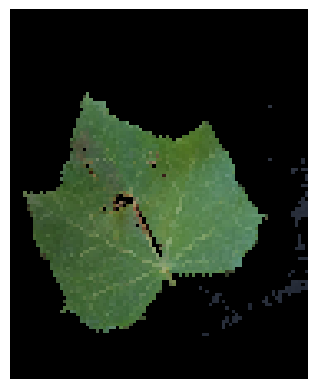

Augmented image shape: torch.Size([3, 112, 90])


In [3]:
# Choose a test image
image_index = 705

#Load augmented images
augmented_file_name = './data/augmented_leaves_dataset_categories.pkl'
with open(augmented_file_name, 'rb') as f:
    loaded_data = pickle.load(f)

x_train = loaded_data['x_train']
x_test = loaded_data['x_test']
y_train = loaded_data['y_train']
y_test = loaded_data['y_test']

plt.figure()
plt.imshow(convert_torch_for_plotting(x_train[image_index], normalized=True))
plt.axis('off')
plt.show()

t = x_train[image_index]
print(f'Augmented image shape: {t.shape}')

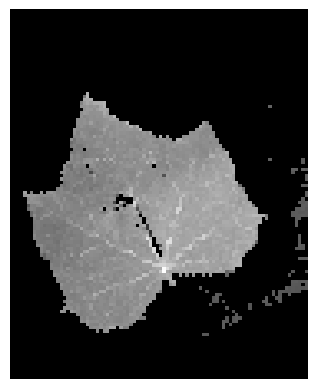

Radians range for rotations: -1.57080 to 1.57080
[Number of patches, patch size]: torch.Size([9879, 4])
Expected feature map out [H, W]: (111, 89)


In [4]:
# Everything in this cell is just testing the greyscale change & strides (incorporated into run_quantum_kernel_filter below)
# NOTE - This test is run on greyscale images, but could be run with different J1/J2/B/sampling parameters per RGB channel

t_grey = convert_to_greyscale(t)

plt.figure()
plt.imshow(normalize_greyscale(t_grey).numpy(), cmap='grey')
plt.axis('off')
plt.show()

print(f'Radians range for rotations: {normalize_greyscale(t_grey).min():.5f} to {normalize_greyscale(t_grey).max():.5f}')

# Extract 2x2 patches with stride=1 (overlapping)
patches = extract_patches(t_grey, kernel_size=2, stride=1)
print(f'[Number of patches, patch size]: {patches.shape}')

# View shape of feature map
H_out = (t_grey.shape[0] - 2) // 1 + 1
W_out = (t_grey.shape[1] - 2) // 1 + 1

print(f'Expected feature map out [H, W]: {H_out, W_out}')

Changing sample count while holding other parameters constant.
- Increasing sample count decreases noise
- Sampling / shots_count parameter competes with J1 / J2 / B 
    (i.e., low-sampling noise can be offset by increasing J1 / J2 / B magnitudes, or vice-versa)


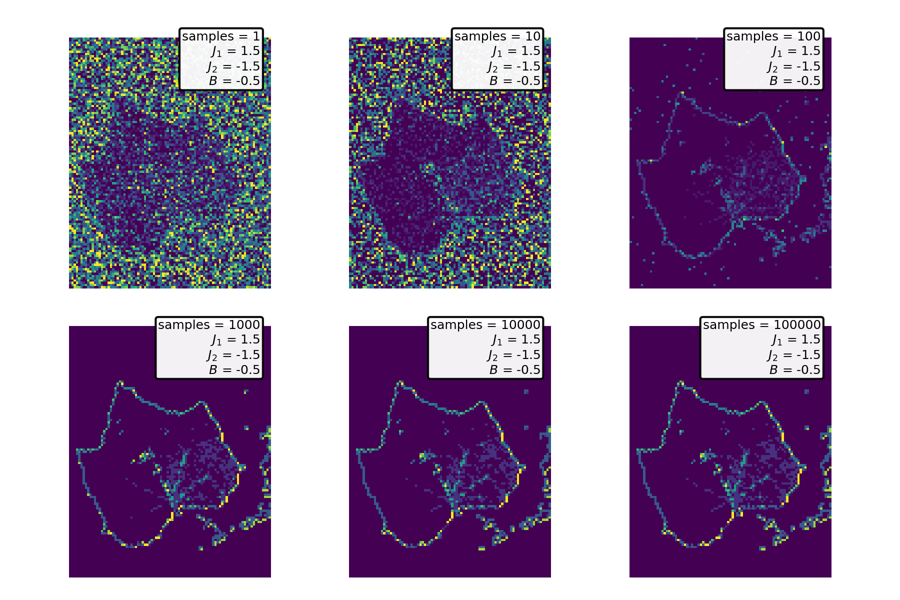

In [5]:
# EXAMPLE - sampling:
# Shows sampling effect on output. Constant J1/J2/B with varying shots_count (samples).

j1_inp = 1.5
j2_inp = -1.5
z_inp = -0.5

sampling=[]
for sample_ct in [1, 10, 100, 1000, 10000, 100000]:
    
    # Runs the kernel with given frustrated parameters and appends to running list
    t_out = run_quantum_kernel_filter(t, is_greyscale=False, stride=1, kernel_size=2, quantum_kernel=kernel, 
                                      zeeman_strength=z_inp, j1=j1_inp, j2=j2_inp, sample_count=sample_ct)
    
    sampling.append((j1_inp, j2_inp, z_inp, sample_ct, t_out))

print('Changing sample count while holding other parameters constant.\n' \
    '- Increasing sample count decreases noise\n' \
    '- Sampling / shots_count parameter competes with J1 / J2 / B \n'
    '    (i.e., low-sampling noise can be offset by increasing J1 / J2 / B magnitudes, or vice-versa)')

# Saves a high-dpi grid of the results in ./data/ & displays a low-dpi one to reduce notebook file size for GitHub
show_images_grid(sampling, rows=2, cols=3, save_path='./data/sampling_example.png', font_size=6, high_dpi=300, low_dpi=50)

Holding sample count & B constant while changing J1 / J2. - Note: Increasing sample count allows the relative strength of J1/J2/B to be smaller, as noted in the previous example.


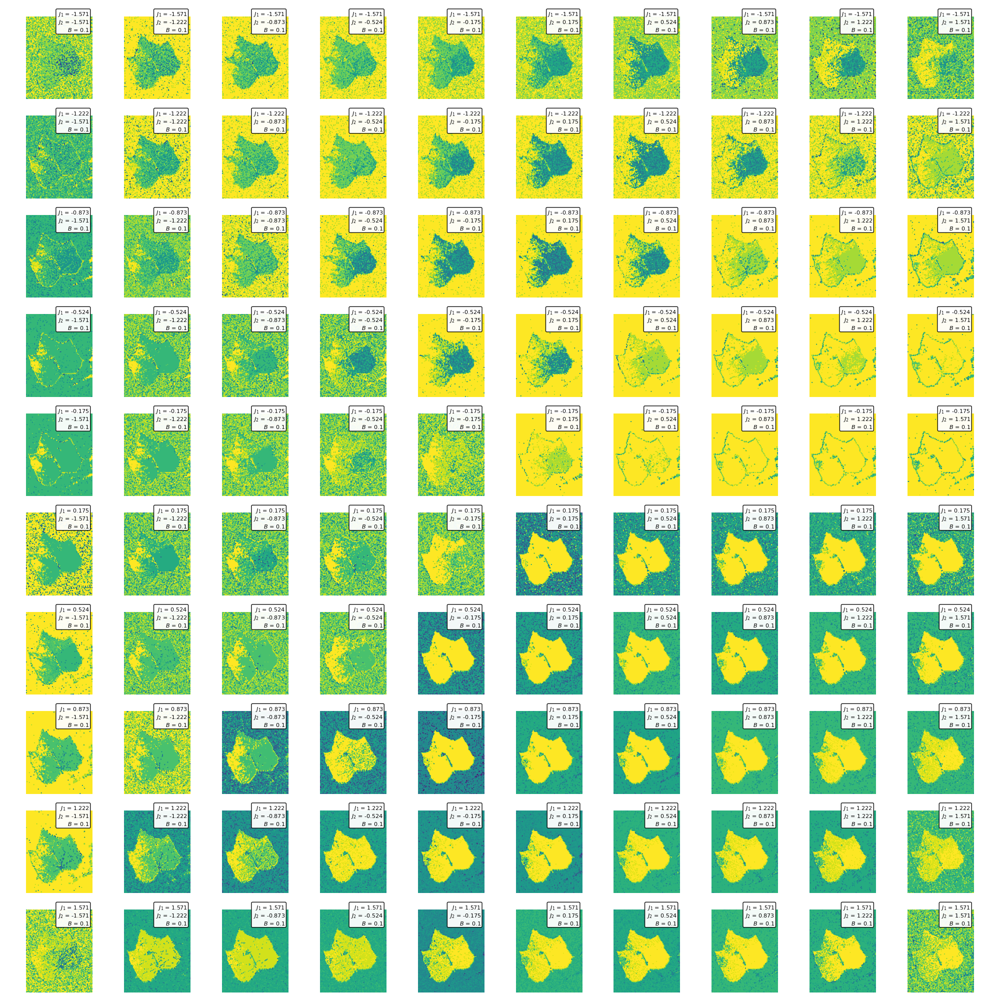

In [11]:
# EXAMPLE - J1/J2 competition:
# Shows the effect of J1/J2 variations on kernel's filtered image result. Constant samples & B.

samples = 1000
z = 0.1
j1_range = np.linspace(-np.pi/2., np.pi/2., 10)
j2_range = np.linspace(-np.pi/2., np.pi/2., 10)

q_volved_j1j2=[]
for j in j1_range:
    for k in j2_range:
        t_out = run_quantum_kernel_filter(t, is_greyscale=False, stride=1, kernel_size=2, quantum_kernel=kernel, 
                                          zeeman_strength=z, j1=j, j2=k, sample_count=samples) 
        q_volved_j1j2.append((j,k,z,t_out))

print('Holding sample count & B constant while changing J1 / J2. ' \
    '- Note: Increasing sample count allows the relative strength of J1/J2/B to be smaller, as noted in the previous example.')

show_images_grid(q_volved_j1j2, rows=10, cols=10, save_path='./data/j1j2_example.png', font_size=8, high_dpi=100, low_dpi=50)

In [ ]:
# EXAMPLE - B field sweeping:
# Shows how the Zeeman term (B) results in varying feature extractions. Constant J1/J2 and samples.

samples = 1000
z_range = np.linspace(-np.pi, np.pi, 100)
j1=1.5
j2=-1.5

b_sweep=[]
for z in z_range:
    t_out = run_quantum_kernel_filter(t, is_greyscale=False, stride=1, kernel_size=2, quantum_kernel=kernel, 
                                      zeeman_strength=z, j1=j1, j2=j2, sample_count=samples)
    b_sweep.append((j1,j2,z,t_out))
    
print('Holding sample count / J1 / J2 constant while changing B.')
show_images_grid(b_sweep, rows=10, cols=10, save_path='./data/B_example.png', font_size=8, high_dpi=100, low_dpi=50)

In [ ]:
# EXAMPLE - J1/J2/B competition:
# Expands on the previous examples to show how all 3 conceptual parameters from the frustrated Hamiltonain
# alter kernel's filtered image results.

samples = 1000
z_range = np.linspace(0, np.pi, 10) # NOTE: Holding to positive B values to reduce plot size for GitHub.
j1_range = np.linspace(-np.pi, np.pi, 5)
j2_range = np.linspace(-np.pi, np.pi, 5)

q_volved=[]
for z in z_range:
    for j in j1_range:
        for k in j2_range:
            t_out = run_quantum_kernel_filter(t, is_greyscale=False, stride=1, kernel_size=2, quantum_kernel=kernel, 
                                              zeeman_strength=z, j1=j, j2=k, sample_count=samples)
            q_volved.append((j,k,z,t_out))

print('Holding sample count constant while changing J1 / J2 / B.' \
    '- Smoother/tighter parameter combinations will result in less drastic changes between filtered images.')
show_images_grid(q_volved, rows=25, cols=10, save_path='./data/j1j2B_example.png', font_size=8, high_dpi=100, low_dpi=50)